In [20]:
import torch
import torch.nn as nn
import joblib
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

from data import iid
from network import teacher, student, base, ensemble
from solver import rl_solver, ode

In [ ]:
np.power(10, [])

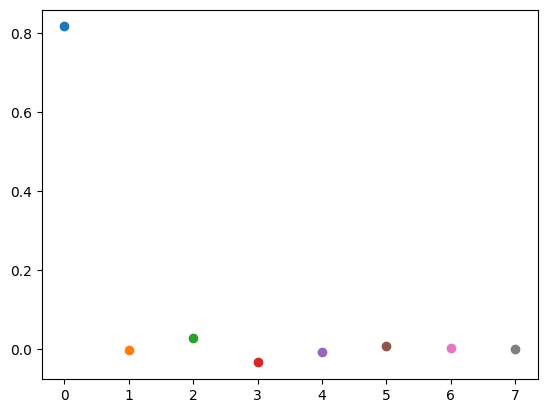

In [392]:
for n in np.arange(8):
    x=np.random.normal(0, 1, np.power(10, n))
    delta = 1-x@x.T/np.power(10, n)
    plt.scatter(n, delta)

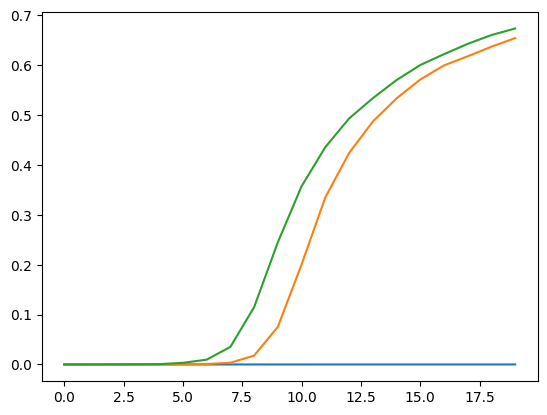

In [408]:
l = 3
chain_num = 5
logdir = glob.glob(f'../composite_learning/logs/len_{l}_chain_{chain_num}/*/')
for p in logdir:
    plt.plot(joblib.load(f'{p}/baseline/history.jl')['exp_reward'][:20])

In [378]:
l = 3
chain_num = 4
logdir = glob.glob(f'../composite_learning/logs/len_{l}_chain_{chain_num}/*/')[-1]
baseline = joblib.load(f'{logdir}/baseline/history.jl')
chain_history = []
for i in range(chain_num):
    chain_history.append(joblib.load(f'{logdir}/chain{i}/history.jl'))

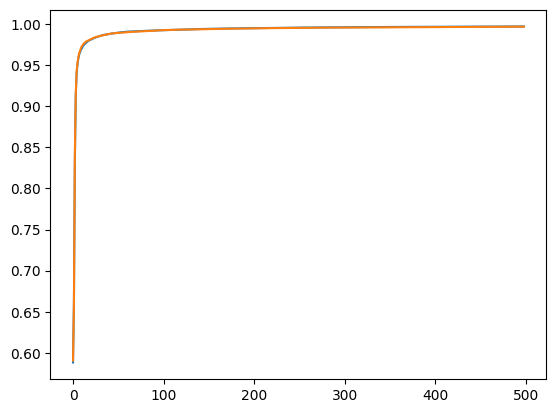

In [379]:
plt.plot(baseline['exp_reward1'])
plt.plot(baseline['exp_reward2'])
#plt.plot(baseline['exp_reward3'])

In [380]:
def load_model(p, n):
    teachers = []
    students = []
    
    for i in range(n):
        s = student.ContinuousStudent(input_dimension=100, hidden_dimensions=[1], nonlinearity = 'sign')
        t = teacher.ContinuousTeacher(input_dimension=100, hidden_dimensions=[1], nonlinearity = 'sign')
        student_ckp=os.path.join(p, f'student_{i}_last.pt')
        teacher_ckp=os.path.join(p, f'teacher_{i}_last.pt')
        s.load_state_dict(torch.load(student_ckp))
        t.load_state_dict(torch.load(teacher_ckp))
        teachers.append(t)
        students.append(s)
    return teachers, students

baseline_teacher, baseline_student = load_model(f'{logdir}/baseline/', chain_num)
chain_students = []

for i in range(chain_num):
    _, chain_student = load_model(f'{logdir}/chain{i}/',1)
    if i != (l-1):
        chain_students+=[chain_student[0]]
    if i == (l-1):
        chain_students+=chain_student
        

rl_transient_task = iid.TransientRLTask(batch_size= 1, seq_len = [l]*chain_num, input_dim = 100)


baseline_solver = rl_solver.ChainedRLPerceptronSolver(criterion = nn.MSELoss(), logdir = '.', optimizer_type = 'sgd', 
                                              lr = None, lr_positive = 10, lr_negative = None, weight_decay =0, teacher_network = baseline_teacher, student_network = baseline_student)

chained_solver = rl_solver.ChainedRLPerceptronSolver(criterion = nn.MSELoss(), logdir = '.', optimizer_type = 'sgd', 
                                              lr = None, lr_positive = 10, lr_negative = None, weight_decay =0, teacher_network = baseline_teacher, student_network = chain_students)


Time to post init solver: -0.0008835792541503906
Time to post init solver: -0.0031845569610595703


In [381]:
c=0
c_naive = 0
for i in range(1000):
    x = rl_transient_task.get_batch()['x']
    teacher_output, student_output = chained_solver._inference(x)
    teacher_output_naive, student_output_naive =baseline_solver._inference(x)
    if torch.all(teacher_output == student_output):
        c+=1
    if torch.all(teacher_output_naive == student_output_naive):
        c_naive+=1
print(c, c_naive)

890 958


0 9
1 6
2 3
3 0
0


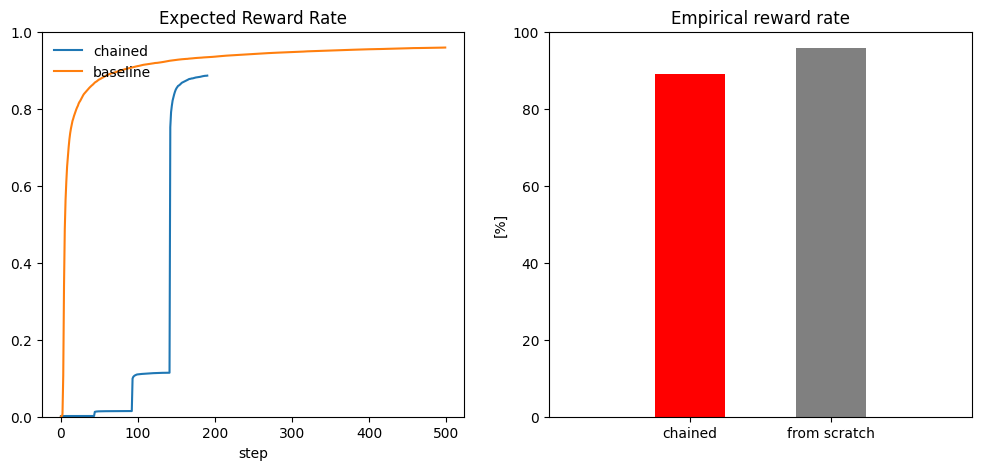

In [382]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)


def make_loss_plot(chains, seq_len):
    tot_loss = []
    num_chain = len(chains)
    tot_len = (num_chain * seq_len)
    learned = 1
    for i in range(num_chain):
        len_rest = tot_len - (i+1)*seq_len
        print(i, len_rest)
        loss= list((np.array(chains[i]['exp_reward1'])**seq_len)* learned * (0.5 ** len_rest))
        learned *= chains[i]['exp_reward1'][-1]**seq_len
        
        tot_loss+=loss
        
    return tot_loss

#ax1.plot(list((np.array(chain1['exp_reward1'])**l) *(np.array(chain1['exp_reward2'])**l) * chain2['exp_reward2'][0])\
#         + list(np.array(chain2['exp_reward'])* (chain1['exp_reward1'][-1]**l)), label = 'chained')
chained_loss = make_loss_plot(chain_history, l)
ax1.plot(chained_loss, label = 'chained')
ax1.plot(baseline['exp_reward'], label = 'baseline' )
ax1.set_ylim(0, 1)
ax1.set_title('Expected Reward Rate')
ax1.set_xlabel('step')
#ax1.set_xticks(np.linspace(0, len(baseline['exp_reward']), 5))
plt.legend(loc = 'upper left', frameon=False)


ax2 = plt.subplot(122)
ax2.bar([0.24], [c/1000*100], width = 0.01, color= 'red')
ax2.bar([0.26], [c_naive/1000*100], width = 0.01, color= 'gray')
ax2.set_ylim(0, 100)
ax2.set_xlim(0.22,0.28)
ax2.set_ylabel('[%]')
ax2.set_title('Empirical reward rate')
ax2.set_xticks([0.24, 0.26])
ax2.set_xticklabels(['chained', 'from scratch'])


print(baseline['num_update'])

In [223]:
chain_history[1]['exp_reward1'][100]

0.9909229874610901

In [19]:
len(chained_loss)

317

In [14]:
54*1000

54000

In [32]:
print(len(chain_history[0]['exp_reward']))
print(baseline['exp_reward4'][-1])

100
0.9858560562133789


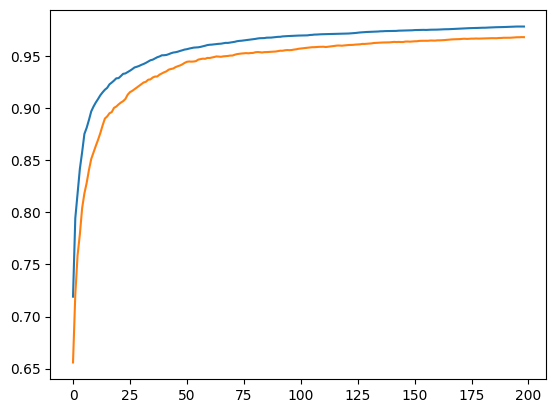

In [45]:
plt.plot(chain_history[0]['exp_reward1'])
plt.plot(chain_history[0]['exp_reward2'])

In [363]:
def plot(seq_length, num_chain, ax, baseline_bool, chained_bool):
    
    paths = glob.glob(f'ode_logs/len_{seq_length}_chain_{num_chain}/*/')
    if len(paths)!=0:
        for path in paths:
            if os.path.isfile(os.path.join(path, 'baseline.jl')):
                baseline = joblib.load(os.path.join(path, 'baseline.jl'))
                if baseline_bool:
                    ax.plot(baseline['exp_reward'], c = 'k', alpha = l*n/24, label = f'Len{l}_chain{n}')
            if os.path.isfile(os.path.join(path, 'chained.jl')):
                chained = joblib.load(os.path.join(path, 'chained.jl'))
                if chained_bool:
                    ax.plot(chained['exp_reward'], c = 'red')

    
def find_critical_point(path,seq_length, num_chain):
    baseline = joblib.load(os.path.join(path, 'baseline.jl'))
    chained = joblib.load(os.path.join(path, 'chained.jl'))
    score = 0.9 **(seq_length * num_chain)
    baseline_i = np.where(np.array(baseline['exp_reward'])>=score)[0]
    chained_i = np.where(np.array(chained['exp_reward'])>=score)[0]
    if len(baseline_i)>0 and len(chained_i)>0:

        return baseline_i[0], chained_i[0], baseline_i[0]/chained_i[0], seq_length*num_chain
    else:
        return np.nan, np.nan

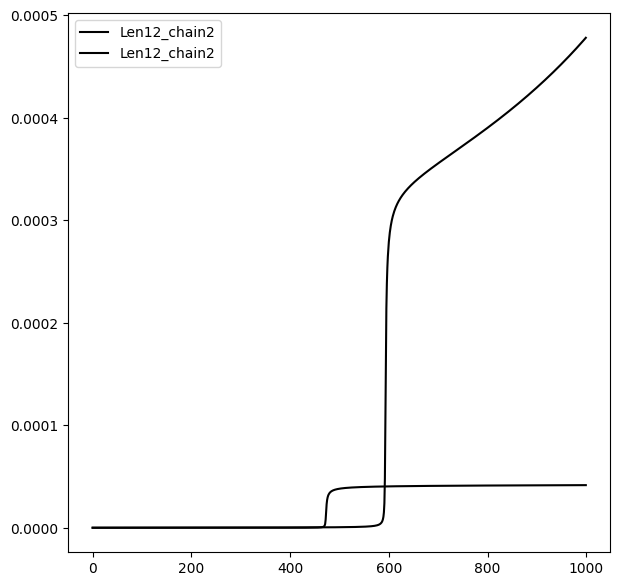

In [377]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
for l in [12]:
    for n in [2]:
        plot(l,n, ax, True, False)
plt.legend()

In [357]:
res_dict = {}
for l in [3,5,6,7,8,9,10,11,12,13,14,15]:
    for n in [2,3,4,5,6,7,8,9]:
        k= find_critical_point(l,n)
        if k is not None:
            res_dict[(l,n)] = k

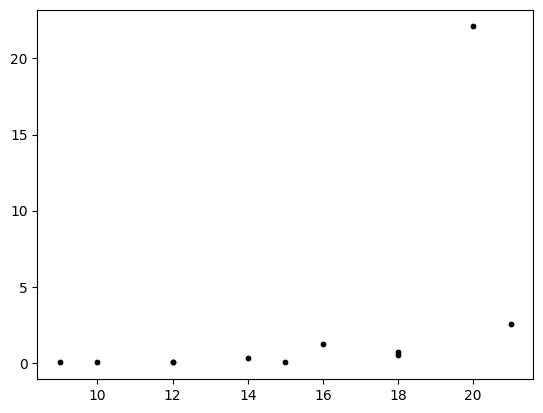

In [358]:
y=[]
x=[]
for k,v in res_dict.items():
    if len(v)==4:
        plt.scatter(v[-1], v[-2], c= 'k' , s=10)
        x.append(v[-1])
        y.append(v[-2])


In [334]:
np.polyfit(x, y, 1)

array([ 0.81086581, -9.64602595])

In [340]:
xs=np.linspace(10, 20, 100)
ys = xs*0.8108-9.646


In [192]:
joblib.load('ode_logs/len_5_chain_3/20230511191604/teachers.jl')['teachers'][3]

IndexError: list index out of range

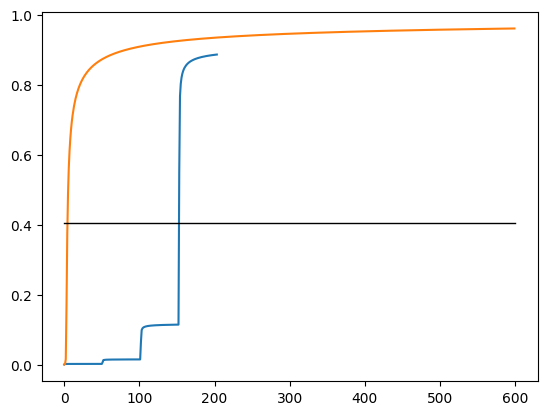

In [172]:
plt.plot(chained['exp_reward'][:600])
plt.plot(baseline['exp_reward'][:600])
score = 0.99**(l*n)
plt.plot((0, 600), (score,score), linewidth=1, c='k')

In [174]:
0.99**(90)

0.4047319726783238

In [74]:
chained['P']

[0.5000991537120096,
 0.9470247650386564,
 0.9655784842673709,
 0.9725994729108991,
 0.9765325217361248,
 0.9791274563041916,
 0.9810028568541114,
 0.9824395714075381,
 0.9835857417589298,
 0.9845278149964504,
 0.9853200573351528,
 0.9859984730942197,
 0.9865880121324253,
 0.9871065814882382,
 0.9875674107050922,
 0.9879805137575934,
 0.9883536288260606,
 0.9886928428610554,
 0.9890030186949264,
 0.9892880944578046,
 0.9895512980911293,
 0.9897953040141854]

In [63]:
path

'ode_logs/len_7_chain_2/20230511100441/'